In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df
from helpers import get_peaks_and_valleys
from helpers import plot_df
from helpers import get_num_reps
from helpers import smooth_and_resample

from tcn import TCN
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GRU
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  "../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                  "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                  "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

validation_files = [
                    "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv", 
                    "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv", 
                    "../data2/row/row_udai_set3_reps10_1.csv", 
                    "../data2/dead/dead_udai_set1_reps10_1.csv", 
                    "../data2/squat/squat_udai_set3_reps10_1.csv"] 

validation_labels = [0, 1, 2, 3, 4] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              "../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              "../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    2823131   -0.607   -9.600   -2.028   0.089  -0.117  -0.039
1    2823134   -0.607   -9.600   -2.039   0.089  -0.117  -0.039
2    2823138   -0.577   -9.570   -2.039   0.109  -0.123  -0.043
3    2823245   -0.621   -9.514   -2.047   0.049  -0.108  -0.046
4    2823282   -0.650   -9.497   -2.061   0.092  -0.106  -0.046
peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleyvals: [(20, -2.389), (165, -13.875)]
peaks: [ 41 181 311], peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleys: [ 20 165], valleyvals: [(20, -2.389), (165, -13.875)]


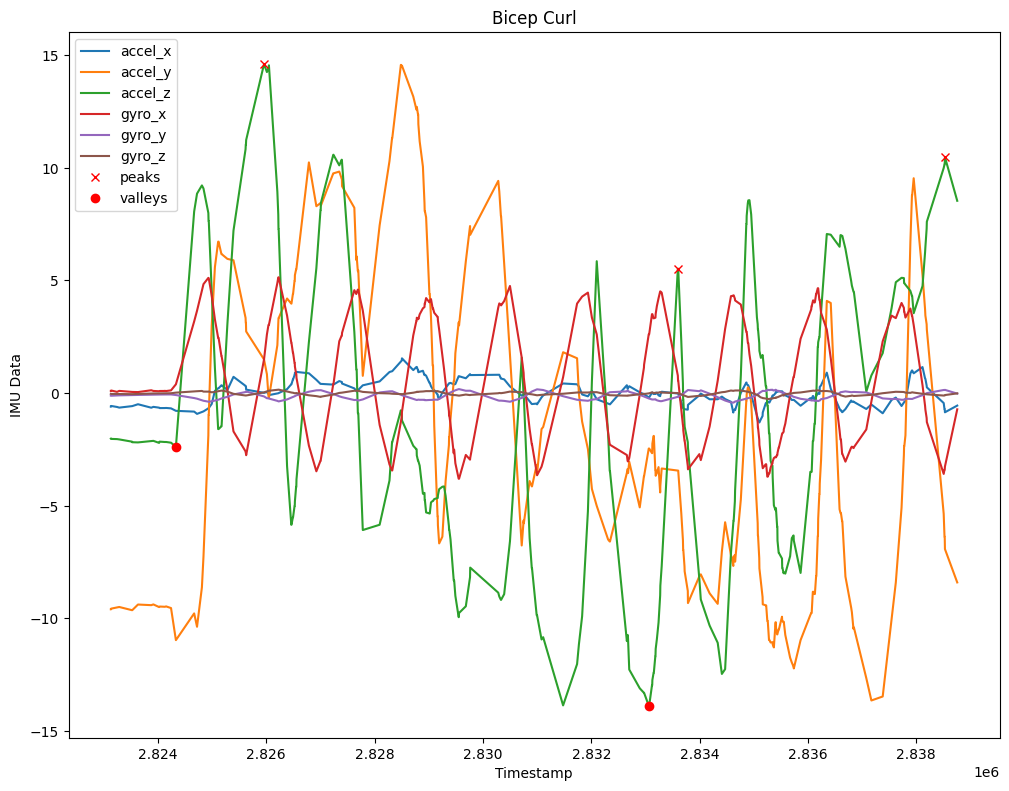

-8.132
valley_outlier_indices: [0 1]
10.192
peak_outlier_indices: []
valid_valley_idxs: []
valid_peak_idxs: [41, 181, 311]
start: 0, end: 313
num_valid_peaks: 3, num_valid_valleys: 0


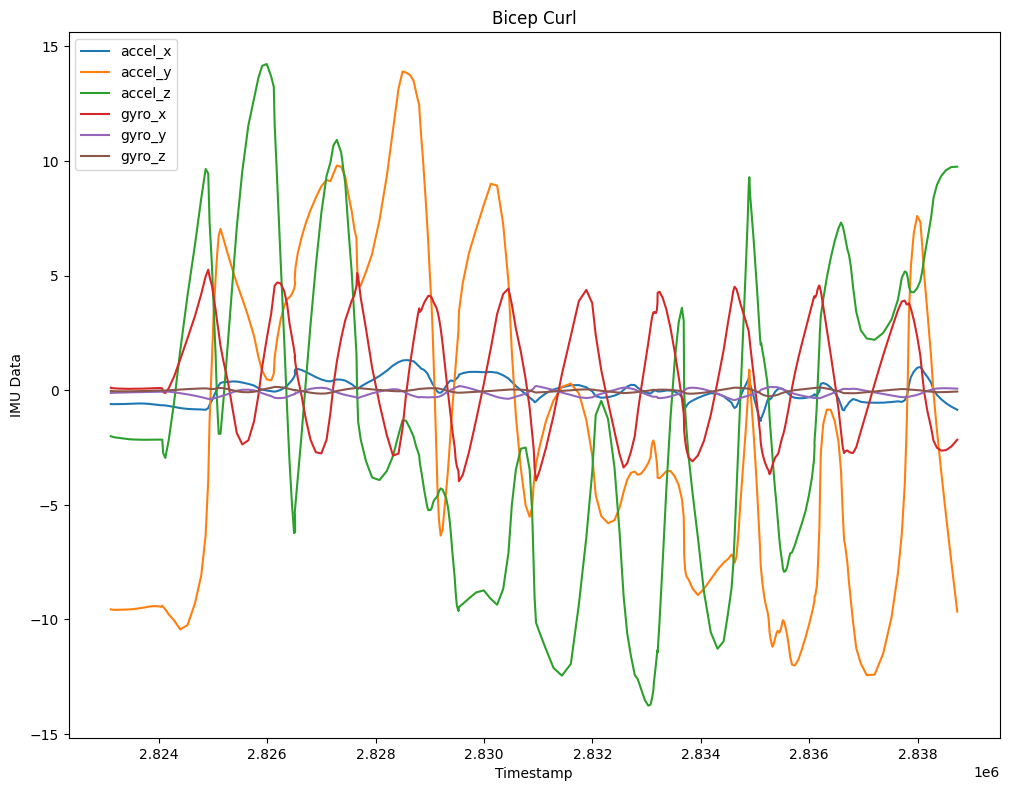

In [3]:
file = "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv"
df = create_df(file)
peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
plot_df(df, "Bicep Curl", peaks, valleys)
start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)

df = df.iloc[start:end]
df = smooth_and_resample(df)
plot_df(df, "Bicep Curl")

In [4]:
def cropped_df(file):
    df = create_df(file)
    peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
    start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)
    # df = df.iloc[start:end]
    print(f"file: {file}, len(df): {len(df)}")
    return df

In [5]:
X_train = []
X_validation = []
X_test = []
max_len = 100

for f in training_files.keys():
    print(f"train: {f}")
    df = cropped_df(f)
    df = smooth_and_resample(df)
    max_len = max(max_len, len(df))
    X_train.append(df)

# for f in validation_files:
#     print(f"validation: {f}")
#     df = cropped_df(f)
#     df = smooth_and_resample(df)
#     max_len = max(max_len, len(df))
#     X_validation.append(df)

for f in test_files.keys():
    print(f"test: {f}")
    df = cropped_df(f)
    df = smooth_and_resample(df)
    max_len = max(max_len, len(df))
    X_test.append(df)

y_train = np.array(list(training_files.values()))
# y_validation = np.array(validation_labels)
y_test = np.array(list(test_files.values()))

train: ../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007
peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1188, 12.439), (1366, 12.207), (1562, 12.272), (1752, 12.193), (1910, 11.174)]
valleyvals: [(142, -5.234), (330, -7.138), (527, -7.144), (710, -7.452), (904, -7.908), (1075, -8.465), (1264, -9.249), (1455, -8.989), (1631, -8.171), (1821, -8.157)]
peaks: [  70  258  450  640  817  999 1188 1366 1562 1752 1910], peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

train: ../data2/row/row_udai_set3_reps10_1.csv
../data2/row/row_udai_set3_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     666760   -0.197    1.819    9.986   0.469  -0.114  -0.055
1     666763   -0.197    1.819    9.986   0.391  -0.116  -0.055
2     666767   -0.197    1.819    9.986   0.391  -0.116  -0.055
3     666771   -0.182    1.923    9.960   0.281  -0.112  -0.057
4     666793   -0.185    1.942    9.869   0.002  -0.097  -0.066
peakvals: [(48, 13.804), (259, 13.679), (466, 15.423), (635, 15.44)]
valleyvals: []
peaks: [ 48 259 466 635], peakvals: [(48, 13.804), (259, 13.679), (466, 15.423), (635, 15.44)]
valleys: [], valleyvals: []
nan
valley_outlier_indices: []
14.5865
peak_outlier_indices: []
valid_valley_idxs: []
valid_peak_idxs: [48, 259, 466, 635]
start: 0, end: 708
num_valid_peaks: 4, num_valid_valleys: 0
file: ../data2/row/row_udai_set3_reps10_1.csv, len(df): 708
train: ../data2/dead/dead_udai_set1_reps10_1.csv
../data2/dead/dead_udai_set1_r

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

In [6]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    arr = df[['accel_x','accel_y','accel_z','gyro_x','gyro_y','gyro_z']].values
    # print(len(arr))
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        print(f"padding")
        pad = np.zeros((max_len - len(arr), 6))
        return np.vstack((arr, pad))


max_len: 300


In [7]:
X_train = np.array([pad(df, max_len) for df in X_train])
# X_validation = np.array([pad(df, max_len) for df in X_validation])
X_test = np.array([pad(df, max_len) for df in X_test])

X_train = np.stack(X_train, axis=0)
# X_validation = np.stack(X_validation, axis=0)
X_test = np.stack(X_test, axis=0)

print(f"training_files.values(): {list(training_files.values())}")

num_classes = 5
y_train = to_categorical(list(training_files.values()), num_classes)
# y_validation = to_categorical(y_validation, num_classes)
y_test = to_categorical(list(test_files.values()), num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

training_files.values(): [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3, 3]
X_train shape: (44, 300, 6)
y_train shape: (44, 5)
X_test shape: (37, 300, 6)
y_test shape: (37, 5)


In [8]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 296, 64)        │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 296, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 148, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,949 (605.27 KB)

 Trainable params: 154,821 (604.77 KB)

 Non-trainable params: 128 (512.00 B)

In [9]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [10]:
# param_grid = {
#     'lstm_units': [32, 64, 128],
#     'dropout_rate': [0.2, 0.3, 0.5],
#     'learning_rate': [0.001, 0.0005],
#     'batch_size': [16, 32],
#     'epochs': [30, 50]
# }
# grid = RandomizedSearchCV(estimator=model,
#                           param_distributions=param_grid,
#                           n_iter=10,
#                           cv=3,
#                           verbose=2)
# grid_result = grid.fit(X_train, y_train)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3143 - loss: 1.5431 - val_accuracy: 0.1111 - val_loss: 1.5902
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5143 - loss: 1.3233 - val_accuracy: 0.1111 - val_loss: 1.6280
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4857 - loss: 1.2671 - val_accuracy: 0.0000e+00 - val_loss: 1.7365
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6286 - loss: 1.0618 - val_accuracy: 0.0000e+00 - val_loss: 1.9250
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4857 - loss: 1.0738 - val_accuracy: 0.0000e+00 - val_loss: 1.9173
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5714 - loss: 0.9514 - val_accuracy: 0.1111 - val_loss: 1.8462
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6571 - loss: 0.9178 - val_accuracy: 0.0000e+00 - val_loss: 2.1011
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6857 - loss: 0.9264 - val_accuracy: 0.1111 - v

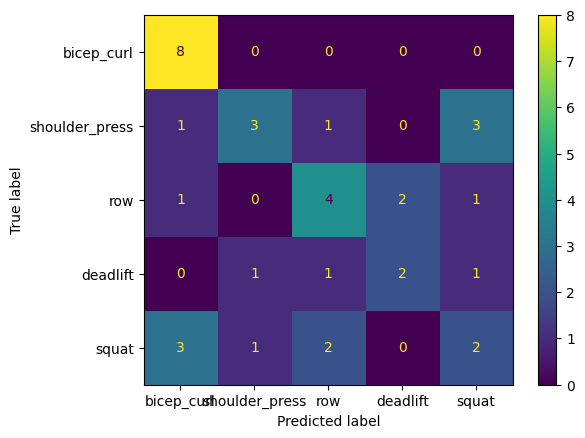

In [11]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=4,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [12]:
for i, y in enumerate(y_pred):
    if y != y_true[i]:
        print(f"misclassified: {list(test_files.keys())[i]}")

misclassified: ../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv
misclassified: ../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv
misclassified: ../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv
misclassified: ../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv
misclassified: ../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv
misclassified: ../data2/row/row_andrew_set2_reps10_1.csv
misclassified: ../data2/row/row_anuj_set2_rep10_1.csv
misclassified: ../data2/row/row_mike_set2_reps10_1.csv
misclassified: ../data2/row/row_udai_set2_reps12_1.csv
misclassified: ../data2/dead/dead_andrew_set2_reps10_1.csv
misclassified: ../data2/dead/dead_anuj_set2_rep10_1.csv
misclassified: ../data2/dead/dead_kamyar_set2_reps10_1.csv
misclassified: ../data2/squat/squat_adam_set2_reps10_1.csv
misclassified: ../data2/squat/squat_jake_set2_reps10_1.csv
misclassified: ../data2/squat/squat_kamyar_set2_reps10_1.csv
misclassified: ../data2/squat/squat_mike_set2_reps10_1.csv
misclassif

In [13]:
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, kernel_size=7, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 294, 64)        │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 294, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 147, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 143, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 143, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 71, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 69, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 69, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,733 (694.27 KB)

 Trainable params: 176,837 (690.77 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1429 - loss: 1.7169 - val_accuracy: 0.2222 - val_loss: 1.7790
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5429 - loss: 1.4571 - val_accuracy: 0.2222 - val_loss: 2.4504
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5143 - loss: 1.5306 - val_accuracy: 0.1111 - val_loss: 2.3225
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5714 - loss: 1.0209 - val_accuracy: 0.1111 - val_loss: 2.6663
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5714 - loss: 1.0021 - val_accuracy: 0.1111 - val_loss: 2.8272
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6000 - loss: 1.1158 - val_accuracy: 0.1111 - val_loss: 2.8737
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6286 - loss: 1.1280 - val_accuracy: 0.1111 - val_loss: 2.8416
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7143 - loss: 0.7198 - val_accuracy: 0.1111 - val_loss:

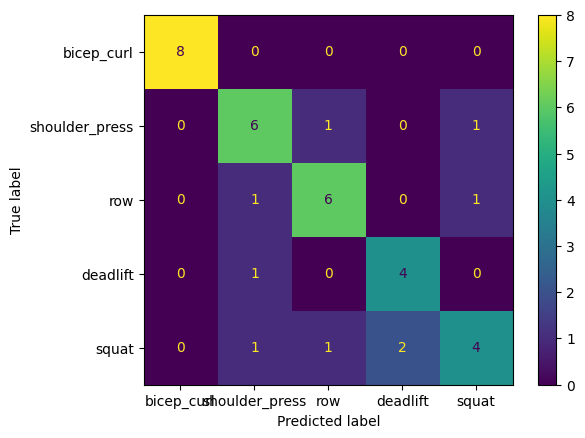

In [14]:
cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=100,
    batch_size=6,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# cnn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [15]:
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 296, 64)        │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 296, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 148, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 148, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,805 (1.42 MB)

 Trainable params: 372,677 (1.42 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.2000 - loss: 1.5093 - val_accuracy: 0.4444 - val_loss: 1.3437
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6286 - loss: 1.1259 - val_accuracy: 0.1111 - val_loss: 1.5048
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5429 - loss: 1.1564 - val_accuracy: 0.1111 - val_loss: 1.5593
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5714 - loss: 1.0085 - val_accuracy: 0.1111 - val_loss: 1.4888
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6286 - loss: 0.9839 - val_accuracy: 0.1111 - val_loss: 1.4635
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6571 - loss: 0.7918 - val_accuracy: 0.1111 - val_loss: 1.5926
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6286 - loss: 0.8405 - val_accuracy: 0.0000e+00 - val_loss: 1.7780
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7714 - loss: 0.6126 - val_accuracy: 0.1111 - val_

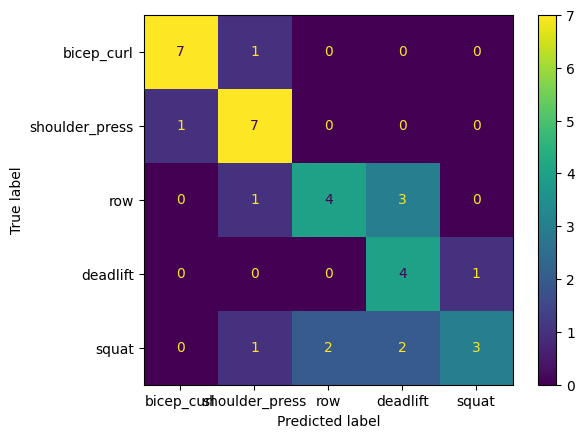

In [16]:
hybrid_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# hybrid_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(hybrid_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [17]:
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=64, kernel_size=5, dropout_rate=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tcn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       228,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,381 (927.27 KB)

 Trainable params: 237,381 (927.27 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
tcn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=4,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1429 - loss: 67.8589 - val_accuracy: 0.2222 - val_loss: 14.4007
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2857 - loss: 19.9375 - val_accuracy: 0.1111 - val_loss: 9.1536
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2000 - loss: 13.5957 - val_accuracy: 0.2222 - val_loss: 6.1030
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2857 - loss: 11.2563 - val_accuracy: 0.2222 - val_loss: 4.4034
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3714 - loss: 7.9448 - val_accuracy: 0.2222 - val_loss: 4.1376
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2857 - loss: 6.4423 - val_accuracy: 0.2222 - val_loss: 3.5680
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3429 - loss: 5.7482 - val_accuracy: 0.1111 - val_loss: 3.2347
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4286 - loss: 5.0150 - val_accuracy: 0.1111 - val_loss: 3.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
y_pred: [0 0 1 3 0 0 0 0 1 4 1 1 1 3 2 4 2 3 3 0 2 3 2 2 3 1 3 2 3 1 4 4 3 1 1 2 0]
y_true: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4 4]
Accuracy: 0.5135135135135135
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.44      0.50      0.47         8
           2       0.57      0.50      0.53         8
           3       0.33      0.60      0.43         5
           4       0.50      0.25      0.33         8

    accuracy                           0.51        37
   macro avg       0.52      0.52      0.50        37
weighted avg       0.53      0.51      0.51        37

[[6 1 0 1 0]
 [0 4 1 1 2]
 [1 0 4 3 0]
 [0 1 1 3 0]
 [1 3 1 1 2]]


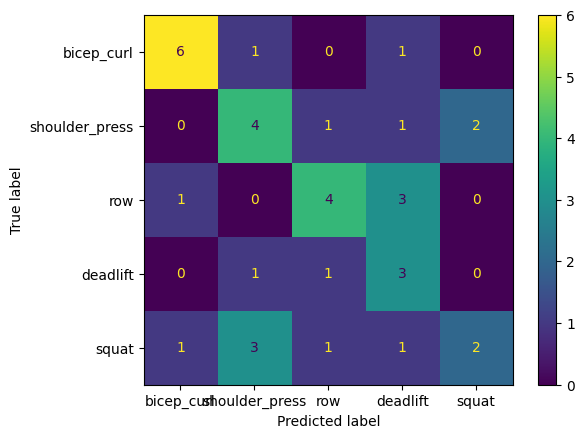

In [19]:
# tcn_model(np.zeros((1, X_train.shape[1], X_train.shape[2])))
# tcn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(tcn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [20]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(input_layer, input_layer)
x = LayerNormalization()(x)

x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

transformer_model = tf.keras.Model(input_layer, output)

transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 300, 6)    │      3,462 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 300, 6)    │         12 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 300, 128)  │        896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        645 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,015 (19.59 KB)

 Trainable params: 5,015 (19.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1714 - loss: 1.6165 - val_accuracy: 0.1111 - val_loss: 1.5790
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4571 - loss: 1.4969 - val_accuracy: 0.1111 - val_loss: 1.6107
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4857 - loss: 1.4085 - val_accuracy: 0.1111 - val_loss: 1.6087
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4571 - loss: 1.3590 - val_accuracy: 0.2222 - val_loss: 1.6251
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4571 - loss: 1.3402 - val_accuracy: 0.2222 - val_loss: 1.5934
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5143 - loss: 1.2687 - val_accuracy: 0.2222 - val_loss: 1.6024
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4286 - loss: 1.2082 - val_accuracy: 0.2222 - val_loss: 1.6106
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6000 - loss: 1.1747 - val_accuracy: 0.2222 - val_loss: 1.5733


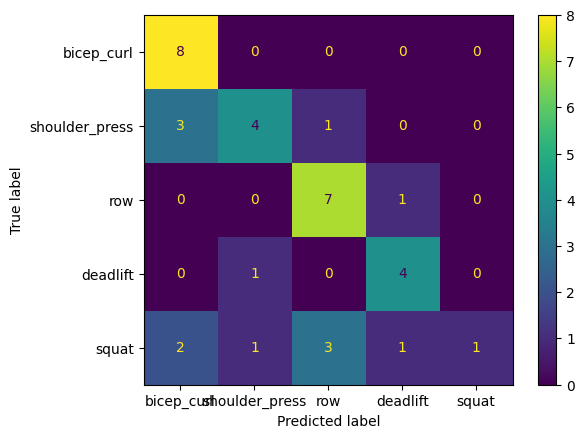

In [21]:
transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=4,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# transformer_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(transformer_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [22]:
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    GRU(128, return_sequences=True),
    Dropout(0.3),

    GRU(64),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 300, 128)       │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,957 (367.02 KB)

 Trainable params: 93,957 (367.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.3143 - loss: 1.5904 - val_accuracy: 0.2222 - val_loss: 1.7568
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5429 - loss: 1.2101 - val_accuracy: 0.1111 - val_loss: 1.9361
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6571 - loss: 0.9953 - val_accuracy: 0.3333 - val_loss: 1.9513
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6000 - loss: 0.9765 - val_accuracy: 0.2222 - val_loss: 2.0316
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6286 - loss: 0.9420 - val_accuracy: 0.1111 - val_loss: 2.1265
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6571 - loss: 0.8514 - val_accuracy: 0.2222 - val_loss: 2.2860
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6571 - loss: 0.8420 - val_accuracy: 0.2222 - val_loss: 2.1236
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6571 - loss: 0.8185 - val_accuracy: 0.2222 - val_loss: 2.0375

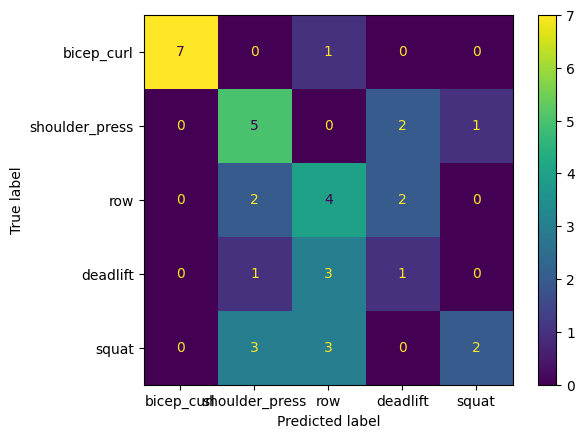

In [23]:
gru_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=50,
    batch_size=4,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# gru_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(gru_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()